# CSE185 Lab 4 Report - Code Documentation (10 pts)

* Document any commands used or additional analysis steps below!
* You should include enough detail that the instructors (or your future self) could come back to this several months from now and know exactly what you did and why you did it.
* We will not run this notebook, but will look back to see what you did especially if you end up with different answers.

For grading purposes only - Do not copy or edit this cell!

In [1]:
# 1.1 Finding how many genes were expressed (TPM>0) in each sample.
cmd = """
cat HFD_Rep2.genes.results | awk '$6>0 {count++} END{print count}'
"""
# repeat for each sample

# 1.2 TPM scatter plots between replicates 1 and 2 for Chow and HFD

import scipy
from scipy.stats import t
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.set_aspect('equal', adjustable='box')
ax1.axis([-0.3,5.5,-0.3,5.5])

ax2 = fig.add_subplot(222)
ax2.set_aspect('equal', adjustable='box')
ax2.axis([-0.3,5.5,-0.3,5.5])


cRep1 = pd.read_csv("~/public/lab4/Chow_Rep1.genes.results", sep="\t")
cRep2 = pd.read_csv("~/public/lab4/Chow_Rep2.genes.results", sep="\t")
merged1 = pd.merge(cRep1, cRep2, on="gene_id", suffixes=("_cRep1", "_cRep2"))

hRep1 = pd.read_csv("~/public/lab4/HFD_Rep1.genes.results", sep="\t")
hRep2 = pd.read_csv("~/public/lab4/HFD_Rep2.genes.results", sep="\t")
merged2 = pd.merge(hRep1, hRep2, on="gene_id", suffixes=("_hRep1", "_hRep2"))

log10_TPM_cRep1 = np.log10(np.add(merged1["TPM_cRep1"], 1))
log10_TPM_cRep2 = np.log10(np.add(merged1["TPM_cRep2"], 1))

log10_TPM_hRep1 = np.log10(np.add(merged2["TPM_hRep1"], 1))
log10_TPM_hRep2 = np.log10(np.add(merged2["TPM_hRep2"], 1))

scipy.stats.pearsonr(log10_TPM_cRep1, log10_TPM_cRep2)
scipy.stats.pearsonr(log10_TPM_hRep1, log10_TPM_hRep2)

ax1.scatter(log10_TPM_cRep1,log10_TPM_cRep2, alpha = 0.5)
ax1.set_xlabel("log10(Chow_Rep1 TPM)", size = 10)
ax1.set_ylabel("log10(Chow_Rep2 TPM)", size = 10)
ax1.set_title("Chow log10(TPM) Rep1 vs. Rep2")

ax2.scatter(log10_TPM_hRep1,log10_TPM_hRep2, alpha = 0.5)
ax2.set_xlabel("log10(HFD_Rep1 TPM)", size = 10)
ax2.set_ylabel("log10(HFD_Rep2 TPM)", size = 10)
ax2.set_title("HFD log10(TPM) Rep1 vs. Rep2")


plt.tight_layout()
plt.savefig("replicate_scatter_plots.png", dpi =200)
plt.close()


In [2]:
# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')



In [4]:
%%time

%%R

library("DESeq2")
library("tximport")

print(packageVersion("tximport"))
print(packageVersion("DESeq2"))


##### List the files and set up metadata #####
files <- c("~/public/lab4/Chow_Rep1.genes.results",
         "~/public/lab4/Chow_Rep2.genes.results",
         "~/public/lab4/Chow_Rep3.genes.results",
         "~/public/lab4/HFD_Rep1.genes.results",
         "~/public/lab4/HFD_Rep2.genes.results",
         "~/public/lab4/HFD_Rep3.genes.results")
conditions <- c(rep("Chow", 3), rep("HFD", 3))
samples <- data.frame("run"=c("Chow_Rep1", "Chow_Rep2", "Chow_Rep3", "HFD_Rep1", "HFD_Rep2", "HFD_Rep3"),
                    "condition"=conditions)
names(files) = samples$run

##### Use "tximport" to convert RSEM results to the format needed by DESeq2 #####

# 1. Import RSEM results with tximport
txi <- tximport(files, type = "rsem")

# 2. Note, we also used txi$length[txi$length == 0] <- 1
# to add a pseudocount of 1 to fix an error with 0-length transcripts
txi$length[txi$length == 0] <- 1

# 3. Load to a deseq dataset from tximport (see DESeqDataSetFromTximport)
ddsTxi <- DESeqDataSetFromTximport(txi, colData = samples, design = ~condition)


###### Filter things with very low counts so we don't waste time on those #####
ddsTxi <- ddsTxi[ rowSums(counts(ddsTxi)) >= 10, ]

##### Perform deseq2 #####

ddsTxi <- DESeq(ddsTxi)

##### Write results to chow_vs_hfd_deseq2.csv ###
res <- results(ddsTxi)
write.csv(as.data.frame(res),"chow_vs_hfd_deseq2.csv")

[1] ‘1.22.0’
[1] ‘1.34.0’


R[write to console]: It looks like you are importing RSEM genes.results files, setting txIn=FALSE

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 32.1 s, sys: 40.4 s, total: 1min 12s
Wall time: 15 s


CPU times: user 1.32 s, sys: 327 ms, total: 1.65 s
Wall time: 1.14 s


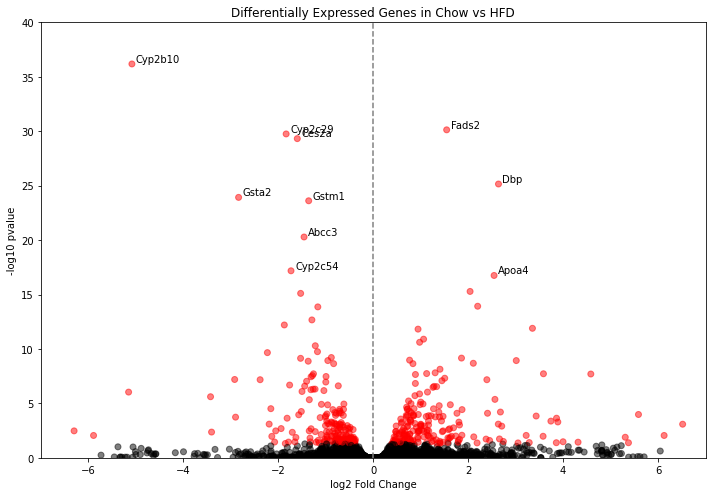

In [5]:
%%time

# 2.4 Making Volcano Plot of log2 fold change vs -log10 p-value

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

deseq = pd.read_csv("chow_vs_hfd_deseq2.csv", index_col=False)

deseq.columns.values[0] = "ENSEMBL"

genes = pd.read_csv("~/public/lab4/GRCm38.75.gene_names", sep ="\t", header = None, names =["gene_id", "gene_name"])

merged_results = pd.merge(deseq, genes, left_on = deseq.columns[0], right_on = "gene_id", how = "left")

fig = plt.figure(figsize=(10,7))
ax3 = fig.add_subplot(111)
ax3.axis([-7,7,0,40])

ax3.scatter(deseq["log2FoldChange"], -np.log10(deseq["padj"]), 
            color = np.where(merged_results["padj"] < 0.05, "red", "black"), alpha = 0.5)

ax3.set_xlabel("log2 Fold Change")
ax3.set_ylabel("-log10 pvalue")
ax3.set_title("Differentially Expressed Genes in Chow vs HFD")

ax3.axvline(0, color="gray", linestyle = "--")

top_genes = merged_results.nsmallest(10, "padj")
             
for i, g in (top_genes.iterrows()):
    ax3.annotate(g["gene_name"], 
                xy=(g["log2FoldChange"], -np.log10(g["padj"])),
                xytext=(4,2),
                textcoords="offset points",
                color = "black")
    
plt.tight_layout()
plt.savefig("Chow_HFD_volcano_plot.png", dpi =200)



In [8]:
%%time

# 2.5 Determining number of differentially expressed genes across 
# both conditions

sig_genes = merged_results[merged_results["padj"] < 0.05]

print("There are",len(sig_genes), "differentially expressed genes across both conditions \n")
print("10 Most Differentially Expressed Genes \n", top_genes[["gene_name", "log2FoldChange", "padj"]])

There are 375 differentially expressed genes across both conditions 

10 Most Differentially Expressed Genes 
       gene_name  log2FoldChange          padj
6184    Cyp2b10       -5.083951  6.573663e-37
3648      Fads2        1.545719  7.392994e-31
427     Cyp2c29       -1.835318  1.765678e-30
11579     Ces2a       -1.600727  4.757641e-30
12021       Dbp        2.637427  7.035740e-26
11829     Gsta2       -2.837015  1.190656e-24
11845     Gstm1       -1.360523  2.436782e-24
2233      Abcc3       -1.457844  5.178033e-21
12672   Cyp2c54       -1.732744  6.605814e-18
6883      Apoa4        2.544864  1.772129e-17
CPU times: user 11.3 ms, sys: 2.25 ms, total: 13.6 ms
Wall time: 11.5 ms


In [16]:
# 3.6. Preparing for gene ontology enrichment analysis using DAVID

deseq_sig = deseq[deseq["padj"]<0.05]


genes_UP = deseq_sig[deseq_sig["log2FoldChange"] > 0]["ENSEMBL"].tolist()
genes_DOWN = deseq_sig[deseq_sig["log2FoldChange"] < 0]["ENSEMBL"].tolist()
genes_list = deseq["ENSEMBL"].tolist()

with open("genes_UP.txt", "w") as file:
    file.write("\n".join(genes_UP))
    
with open("genes_DOWN.txt", "w") as file:
    file.write("\n".join(genes_DOWN))
    
with open("genes_list.txt", "w") as file:
    file.write("\n".join(genes_list))
